# Example 5: Analyzing Spike Train Data

This tutorial demonstrates the end-to-end workflow for analyzing relationships between populations of spiking neurons.

**Goal:**
1.  Demonstrate the use of the `processor_type='spike'`.
2.  Use a sweep to find the characteristic timescale of a relationship.
3.  Show how to perform multiple runs to get a robust, averaged MI estimate.

## 1. Imports and Data Generation

In [1]:
import torch
import numpy as np
import pandas as pd
import neural_mi as nmi
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")

x_spike_data, y_spike_data = nmi.datasets.generate_correlated_spike_trains(
    duration=10, firing_rate=30, delay=0.02
)

## 2. Finding the Timescale with a Sweep

To get a stable result, we'll run the estimation multiple times for each `window_size` by including `run_id` in our `sweep_grid`. The library will automatically average the results.

In [2]:
base_params = {
    'n_epochs': 100, 'learning_rate': 1e-3, 'batch_size': 128,
    'patience': 30, 'embedding_dim': 16, 'hidden_dim': 64, 'n_layers': 2
}

sweep_grid = {
    'window_size': [0.005, 0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.15],
    'run_id': range(5)
}

# When sweeping over a processor parameter like 'window_size',
# the library is now smart enough to handle the processing inside each worker.
sweep_results = nmi.run(
    x_data=x_spike_data,
    y_data=y_spike_data,
    mode='sweep',
    base_params=base_params,
    sweep_grid=sweep_grid,
    processor_type='spike',
    processor_params={'step_size': 0.001}, # Fixed params go here
    n_workers=4,
    random_seed=42,
    verbose=False
)

display(sweep_results.dataframe)

2025-10-04 19:39:56 - neural_mi - WARNING - Reproducibility with random_seed is not guaranteed with n_workers > 1.
2025-10-04 19:39:56 - neural_mi - INFO - Detected sweep over processor parameters. Deferring data processing to workers.
2025-10-04 19:39:56 - neural_mi - INFO - Starting parameter sweep with 4 workers...


Parameter Sweep Progress:   0%|          | 0/40 [00:00<?, ?task/s]

2025-10-04 19:42:16 - neural_mi - INFO - Parameter sweep finished.


,window_size,mi_mean,mi_std
0,0.005,0.000886,0.000642
1,0.010,0.003084,0.006594
2,0.020,0.008055,0.011224
3,0.030,0.067357,0.047552
4,0.050,0.461862,0.145346
5,0.080,0.706822,0.175246
6,0.100,0.998322,0.147016
7,0.150,1.291079,0.332207


### Interpreting the Results: Why an Elbow, Not a Peak?

Before looking at the plot, it's important to understand what we expect to see.

* **What the `SpikeProcessor` Does:** Unlike a continuous signal, spike data consists of discrete events in time. The `SpikeProcessor` takes these lists of spike times and chops them into windows. For each window, it stores the timing of the spikes *relative to the start of that window*. This converts the irregular spike times into a regular 3D tensor that the neural network can process.

* **What the Sweep is Looking For:** We are searching for the characteristic timescale of the relationship. The core relationship in our data is "a spike in X increases the probability of a spike in Y ~20ms later."

* **What to Expect:** For a simple lagged signal (like in Tutorial 2), we see a sharp peak because windows that are too large add unrelated "noise" that hurts the MI estimate.

    For spike data, the interpretation is different.
    * A window smaller than the 20ms delay cannot contain both the cause (X-spike) and the effect (Y-spike), so the MI will be near zero.
    * Once the window is large enough to contain the 20ms relationship, the MI will jump up.
    * As the window gets even larger, it doesn't add noise; instead, it **accumulates more information**. It can capture more complex patterns (e.g., "an X spike, then a Y spike 20ms later, then another X spike 30ms after that").

    Because larger windows contain more potential patterns, the MI for spike data is expected to be a **monotonically increasing curve that saturates**, not a curve with a sharp peak. The most important feature is the **"elbow"** of the curve—the point where the MI begins to rise sharply. This elbow reveals the minimum timescale required to capture the interaction.

## 3. Analyzing and Plotting the Results

The output `Results` object contains an aggregated DataFrame. We can directly plot this to find the optimal timescale.

Window Size with Maximum MI: 150.0 ms


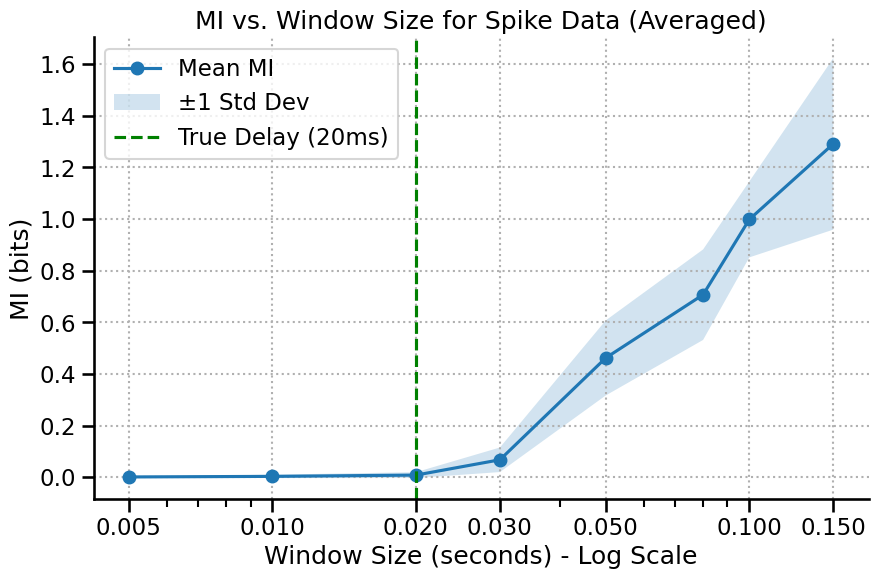

In [3]:
summary_df = sweep_results.dataframe

# Find the optimal window size
best_window_size = summary_df.loc[summary_df['mi_mean'].idxmax()]['window_size']
print(f"Window Size with Maximum MI: {best_window_size*1000:.1f} ms")

# Use the built-in plotting function
ax = sweep_results.plot(show=False)

# Emphasize the elbow of the curve
ax.set_xscale('log')
ax.set_xticks([0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.15])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

ax.axvline(x=0.02, color='green', linestyle='--', label='True Delay (20ms)')
ax.set_xlabel("Window Size (seconds) - Log Scale")
ax.set_title("MI vs. Window Size for Spike Data (Averaged)")
ax.legend()
plt.show()